2026-02-17 04:43:56.320318: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-17 04:43:56.321276: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-17 04:43:56.338180: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-17 04:43:56.338198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-17 04:43:56.338616: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

Epoch 1/100


2026-02-17 04:43:57.835354: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-17 04:43:57.841592: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


782/782 [==============================] - 15s 19ms/step - loss: 1.8307 - accuracy: 0.3181 - val_loss: 1.5673 - val_accuracy: 0.4205 - lr: 0.0010
Epoch 2/100
782/782 [==============================] - 15s 20ms/step - loss: 1.5314 - accuracy: 0.4448 - val_loss: 1.5062 - val_accuracy: 0.4600 - lr: 0.0010
Epoch 3/100
782/782 [==============================] - 18s 22ms/step - loss: 1.3921 - accuracy: 0.4997 - val_loss: 1.3154 - val_accuracy: 0.5308 - lr: 0.0010
Epoch 4/100
782/782 [==============================] - 20s 25ms/step - loss: 1.3047 - accuracy: 0.5321 - val_loss: 1.2617 - val_accuracy: 0.5480 - lr: 0.0010
Epoch 5/100
782/782 [==============================] - 17s 22ms/step - loss: 1.2367 - accuracy: 0.5579 - val_loss: 1.2382 - val_accuracy: 0.5591 - lr: 0.0010
Epoch 6/100
782/782 [==============================] - 21s 27ms/step - loss: 1.1793 - accuracy: 0.5805 - val_loss: 1.2063 - val_accuracy: 0.5732 - lr: 0.0010
Epoch 7/100
782/782 [==============================] - 22s 28ms/

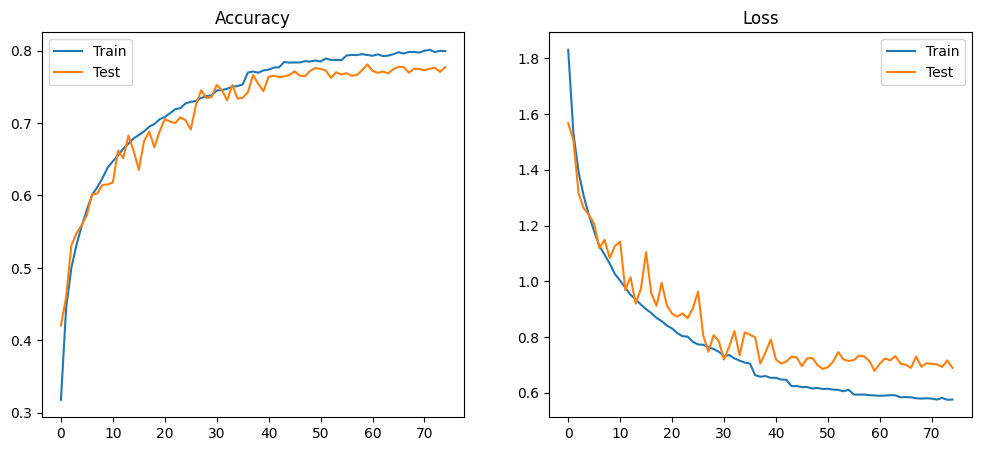

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)
datagen.fit(x_train)

# Model architecture
from tensorflow.keras import layers, models, Input

def build_model():
    inputs = Input(shape=(32, 32, 3))

    # === Block 1 (24 filters with residual connection) ===
    x = layers.Conv2D(28, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(28, (3, 3), padding='same', activation='relu')(x)
    # Residual connection: input -> block output
    shortcut1 = layers.Conv2D(28, (1, 1), padding='same')(inputs)
    x = layers.Add()([x, shortcut1])
    x = layers.MaxPooling2D(pool_size=2)(x)

    # === Block 2 (48 filters with residual connection) ===
    block2_input = x  # store block input for proper residual
    x = layers.Conv2D(56, (3, 3), padding='same', activation='relu')(block2_input)
    x = layers.Conv2D(56, (3, 3), padding='same', activation='relu')(x)
    # Residual connection: block input -> block output
    shortcut2 = layers.Conv2D(56, (1, 1), padding='same')(block2_input)
    x = layers.Add()([x, shortcut2])
    x = layers.MaxPooling2D(pool_size=2)(x)

    # === Global Average Pooling ===
    x = layers.GlobalAveragePooling2D()(x)

    # === Output ===
    outputs = layers.Dense(10, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# Train
history = model.fit(datagen.flow(x_train, y_train, batch_size=64),
                    validation_data=(x_test, y_test),
                    epochs=100,
                    callbacks=[lr_reduction, early_stop],
                    verbose=1)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Plotting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Loss')
plt.legend()
plt.show()

In [2]:
model.save('model_2_15.keras')

In [ ]:
from google.colab import files
files.download("model.keras")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# #Optimized code for GPU

# import tensorflow as tf
# from tensorflow.keras import layers, models, Input
# from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# import matplotlib.pyplot as plt
# import os

# # --- 1. CONFIGURATION & HARDWARE SETUP ---
# # Enable Mixed Precision (faster training on modern GPUs, uses less memory)
# from tensorflow.keras import mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

# # Initialize MirroredStrategy for Multi-GPU training
# strategy = tf.distribute.MirroredStrategy()
# print(f"Number of devices: {strategy.num_replicas_in_sync}")

# # Scale batch size by number of GPUs
# BATCH_SIZE_PER_REPLICA = 64
# GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# # --- 2. DATA PIPELINE (tf.data) ---
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# # Normalize and cast (Mixed precision works best with unscaled or standard scaled data, 
# # but /255.0 is standard for simple CNNs. Note: Float16 casting happens automatically in layers)
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# y_train = tf.keras.utils.to_categorical(y_train, 10)
# y_test = tf.keras.utils.to_categorical(y_test, 10)

# def get_dataset(x, y, is_training=False):
#     dataset = tf.data.Dataset.from_tensor_slices((x, y))
    
#     if is_training:
#         dataset = dataset.shuffle(buffer_size=1024)
    
#     dataset = dataset.batch(GLOBAL_BATCH_SIZE)
    
#     # Prefetch uses extra CPU threads to prepare the next batch while GPU trains
#     dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
#     return dataset

# train_ds = get_dataset(x_train, y_train, is_training=True)
# test_ds = get_dataset(x_test, y_test, is_training=False)

# # --- 3. MODEL ARCHITECTURE (With GPU Augmentation) ---
# def build_model():
#     inputs = Input(shape=(32, 32, 3))

#     # GPU-Accelerated Data Augmentation Layers
#     # These run on the GPU during training only
#     x = layers.RandomFlip("horizontal")(inputs)
#     x = layers.RandomRotation(0.04)(x) # approx 15 degrees
#     x = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(x)

#     # === Block 1 (24 filters + residual) ===
#     x = layers.Conv2D(28, (3, 3), padding='same', activation='relu')(x)
#     x = layers.Conv2D(28, (3, 3), padding='same', activation='relu')(x)
    
#     # Shortcut needs to match dimensions
#     # Note: We apply augmentation to inputs, so we use 'x' flow, 
#     # but for residual logic we need a clean reference. 
#     # In this specific sequential flow, connecting to the start of the block is fine.
#     # However, strictly speaking, the shortcut needs to act on the *output of augmentation*.
#     block1_input = x # Capture state after augmentation/conv1
    
#     # Redefining Block 1 for clarity with the new input flow:
#     # Let's restart the flow cleanly from 'inputs' -> 'aug' -> 'network'
    
#     # Re-structure for clean residual logic:
#     # 1. Augmentation
#     aug = layers.RandomFlip("horizontal")(inputs)
#     aug = layers.RandomRotation(0.04)(aug)
#     aug = layers.RandomTranslation(0.1, 0.1)(aug)
    
#     # Block 1
#     b1 = layers.Conv2D(28, (3, 3), padding='same', activation='relu')(aug)
#     b1 = layers.Conv2D(28, (3, 3), padding='same', activation='relu')(b1)
#     shortcut1 = layers.Conv2D(28, (1, 1), padding='same')(aug)
#     b1 = layers.Add()([b1, shortcut1])
#     b1 = layers.MaxPooling2D(pool_size=2)(b1)

#     # Block 2
#     b2 = layers.Conv2D(56, (3, 3), padding='same', activation='relu')(b1)
#     b2 = layers.Conv2D(56, (3, 3), padding='same', activation='relu')(b2)
#     shortcut2 = layers.Conv2D(56, (1, 1), padding='same')(b1)
#     b2 = layers.Add()([b2, shortcut2])
#     b2 = layers.MaxPooling2D(pool_size=2)(b2)

#     x = layers.GlobalAveragePooling2D()(b2)
    
#     # Separate softmax for numerical stability with mixed precision
#     x = layers.Dense(10)(x)
#     outputs = layers.Activation('softmax', dtype='float32')(x)

#     model = models.Model(inputs, outputs)
#     return model

# # --- 4. COMPILE AND TRAIN INSIDE SCOPE ---
# with strategy.scope():
#     model = build_model()
#     # Optimizer usually needs no change, but Adam is safe
#     model.compile(optimizer='adam', 
#                   loss='categorical_crossentropy', 
#                   metrics=['accuracy'])

# # Callbacks
# lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.5, verbose=1)
# early_stop = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

# print("Starting training...")
# history = model.fit(
#     train_ds,
#     validation_data=test_ds,
#     epochs=100,
#     callbacks=[lr_reduction, early_stop],
#     verbose=1
# )

# # --- 5. EVALUATION ---
# test_loss, test_acc = model.evaluate(test_ds)
# print(f"Test Accuracy: {test_acc * 100:.2f}%")

# # Plotting
# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(history.history['accuracy'], label='Train')
# plt.plot(history.history['val_accuracy'], label='Test')
# plt.title('Accuracy')
# plt.legend()
# plt.subplot(1,2,2)
# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Test')
# plt.title('Loss')
# plt.legend()
# plt.show()
